In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import requests

plt.ion()

In [4]:
move_url = 'http://127.0.0.1:8080/move/train/91/second_15_kfb_150'
requests.get(url=move_url)

<Response [200]>

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [7]:
data_dir = '../training_set/91'

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) \
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10, shuffle=True, num_workers=4) \
    for x in ['train', 'val']
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'val']
}

class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

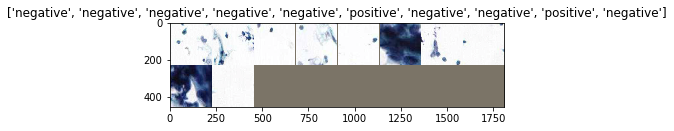

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()      # set the model to training mode
            else:
                model.eval()       # set the model to evalutation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model            

In [12]:
# finetuning the ConvNet
# load a pretrained model and reset final fully connected layer
model_ft = models.resnet50(pretrained=True)
#model_ft.load_state_dict(torch.load('./pretrained_model/resnet50-19c8e357.pth'))
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# decay learning rate by a factor of 0.1 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(model_ft.state_dict(), './official_model.pt')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/django/.torch/models/resnet50-19c8e357.pth
100.0%


Epoch 0/9
----------
train Loss: 0.6450, Acc: 0.7037
val Loss: 0.6650, Acc: 0.6296

Epoch 1/9
----------
train Loss: 0.6269, Acc: 0.6296
val Loss: 0.6262, Acc: 0.6296

Epoch 2/9
----------
train Loss: 0.5395, Acc: 0.7037
val Loss: 0.5458, Acc: 0.6667

Epoch 3/9
----------
train Loss: 0.4903, Acc: 0.8148
val Loss: 0.4653, Acc: 0.8519

Epoch 4/9
----------
train Loss: 0.4038, Acc: 0.8889
val Loss: 0.3735, Acc: 0.9259

Epoch 5/9
----------
train Loss: 0.3289, Acc: 0.9259
val Loss: 0.3082, Acc: 0.8889

Epoch 6/9
----------
train Loss: 0.2269, Acc: 0.9630
val Loss: 0.2661, Acc: 0.9630

Epoch 7/9
----------
train Loss: 0.2705, Acc: 0.8889
val Loss: 0.2610, Acc: 0.9630

Epoch 8/9
----------
train Loss: 0.2372, Acc: 0.9630
val Loss: 0.2595, Acc: 0.9630

Epoch 9/9
----------
train Loss: 0.2383, Acc: 0.9259
val Loss: 0.2458, Acc: 0.9630

Training complete in 3m 2s
Best val Acc: 0.9630
